In [88]:
# Finding common occuring words
import enum
import nltk
import torchvision.transforms as transforms
import os
import torch
import pandas as pd
from transformers import BertTokenizer
from transformers import BertModel
import re
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import pickle
import numpy as np
from torch.utils.data import random_split 
import copy  
from tqdm import tqdm

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  pattern = '[0-9,.()\'-:/&";]'
  cleantext = re.sub(pattern, ' ', cleantext)
  return cleantext.lower()

df = pd.read_csv('IMDB Dataset.csv')
df['review'] = df['review'].apply(cleanhtml)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
df['review'] = df['review'].apply(lambda words: ' '.join([word for word in words.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
import squarify
from collections import Counter
import wordcloud

In [104]:
# iterate through the csv file
# comment_words = ''
# for val in df.review:
     
#     # typecaste each val to string
#     val = str(val)
 
#     # split the value
#     tokens = val.split()
     
#     # Converts each token into lowercase
#     for i in range(len(tokens)):
#         tokens[i] = tokens[i].lower()
     
#     comment_words += " ".join(tokens)+" "


In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(comment_words)
 

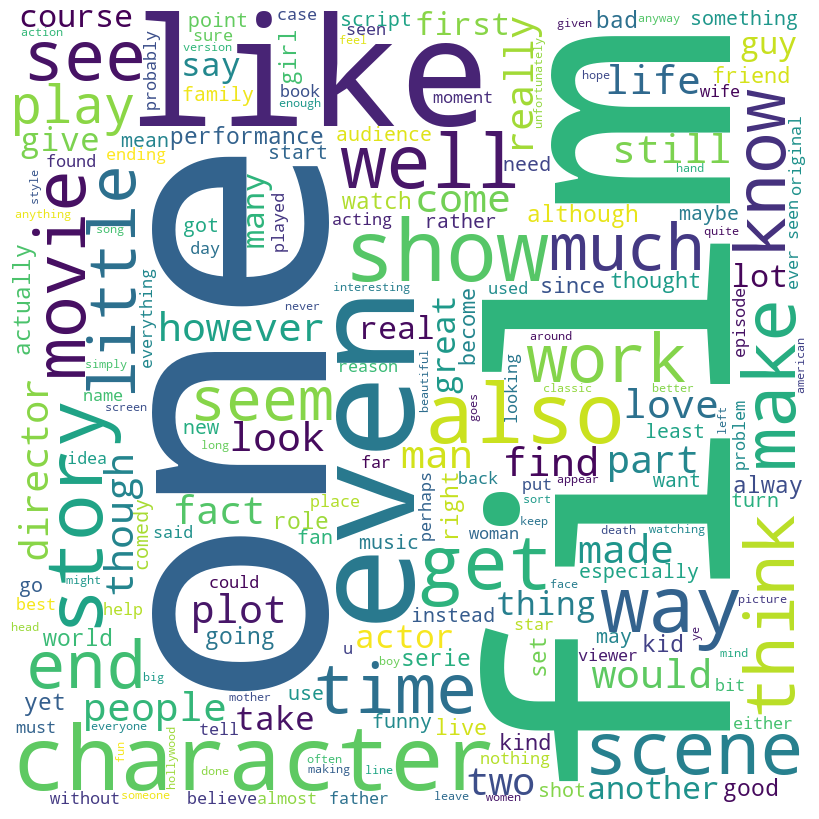

In [107]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [108]:
# words like character, film, scene, story are some keys words to be considered when creating a moview for production

<AxesSubplot:xlabel='sentiment', ylabel='count'>

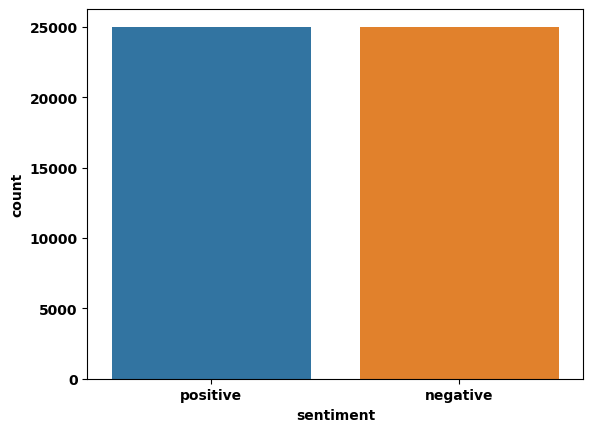

In [84]:
import seaborn as sns
sns.countplot(x=df['sentiment'])
# We have a balanced dataset with equal number of positive and negative reviews

In [42]:
# Text data loader
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    pattern = '[0-9,.()\'-:/&";]'
    cleantext = re.sub(pattern, ' ', cleantext)
    return cleantext.lower()

class Textloader(torch.utils.data.Dataset):
    def __init__(self, root_dir: str = 'IMDB Dataset.csv', max_length: int = 10):
        self.root_dir = root_dir
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f'The file {self.root_dir} does not exist')

        self.data = pd.read_csv(root_dir)
        self.data['review'] = self.data['review'].apply(cleanhtml)
        nltk.download('stopwords')
        stop_words = nltk.corpus.stopwords.words('english')
        self.data['review'] = self.data['review'].apply(lambda words: ' '.join([word for word in words.split() if word not in stop_words]))
        self.description = self.data['review'].to_list()
        self.data['labels'] = self.data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
        self.labels = self.data['labels'].to_list()

        self.num_classes = len(set(self.labels))
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.max_length = max_length 

    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.as_tensor(label).long()   
        description = self.description[index]
        encoded = self.tokenizer.batch_encode_plus([description], max_length=self.max_length, padding='max_length', truncation=True) # every description in list format
        encoded = {key: torch.LongTensor(value) for key, value in encoded.items()}

        with torch.no_grad():
            description = self.model(**encoded).last_hidden_state.swapaxes(1,2)

        description = description.squeeze(0) # remove unnecessary dimension that the CNN model will not use
        return description, label

    def __len__(self):
        return len(self.labels)

In [43]:
def split_dataset(dataset, train_percentage, validation_percentage):
    
    """This function splits the dataset into train, validation, and test and uses dataloader to store the values as iterables
    for all three datasets.
    Args:
        dataset (Dataset): The dataset of features and labels as tuples and torch tensor format
        train_percentage (float): The training percentage of the dataset
        validation_percentage (float): The validation percentage of the dataset
    
    Returns:
        Tuple: Tuple containing train, validation, and test data in form of dataloader objects.
    """
    train_validation = int(len(dataset) * train_percentage)
    validation_split = int(train_validation * validation_percentage)
    test_split = int(len(dataset) - train_validation)

    train_data, test_data = random_split(dataset, [train_validation, test_split], generator=torch.Generator().manual_seed(100))
    train, validation = random_split(train_data, [int(train_validation - validation_split), validation_split], generator=torch.Generator().manual_seed(100))

    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    valid_loader = DataLoader(validation, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    for file_name, dataloader in [('text_train_data.pkl', train_loader), ('text_test_data.pkl', test_loader), ('text_validation_data.pkl', valid_loader)]:
        with open(file_name, 'wb') as file:
            pickle.dump(dataloader, file)

    return train_loader, valid_loader, test_loader

In [44]:
# Early stopping
class EarlyStopping():
    """This class implements regularization during training using early stopping to prevent overfitting
    Args:
        patience (int): Number of times validation loss is allowed to increase in a row every epoch or so.
    """
    def __init__(self, patience=4):

        self.patience = patience
        self.counter = 0
        self.early_stop = False

    def __call__(self, previous_val_loss, curr_val_loss):
        """This magic method compares validation losses and adds to counter if loss increases, else resets the counter
        everytime an instance of the class is called
        
        Args:
            previous_val_loss (float): The validation loss in previous epoch
            curr_val_loss (float): The current validation loss
        """
        if curr_val_loss >= previous_val_loss:
            self.counter +=1
            if self.counter >= self.patience:  
                self.early_stop = True
        else:
            self.counter = 0


# Testing our model to calculate accuracy
def test_accuracy(test_loader, device, model):
    """This function loops through the test data, calculates predictions, locates classes with max probability,
    compares the predictions with the labels and calculates the accuracy.
    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        test_loader (DataLoader): Test data
    Returns:
        float: The accuracy of model predictions 
    """
    model.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(test_loader):
            text, labels = data
            text, labels = text.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(text)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(torch.max(outputs.data, 1))
            total += labels.size(0)
            correct += torch.sum(predicted == labels.data)
    
    accuracy = torch.div(100 * correct.double(), total)
    print(f'Got {correct} / {total}')
    # print('Accuracy of the network on the test images: {} %'.format(accuracy))
    return accuracy


class Classifier(torch.nn.Module):
    """This CNN class uses the torch Sequential module to build layers of the text data neural network which includes 
    convolutional layers, dropout layers, max pooling layers, linear layers with ReLU as activation functions, with
    the last layer having 13 outputs for each category class in the dataset.
    
    Args:
        ngpu (int): The number of CPU cores to use for training
        num_classes (int): The number of classes to predict by the trained model
        input_size (int): The input dimension fed into first Convolutional layer
    
    """

    def __init__(self, ngpu, num_classes, input_size=768):
        super(Classifier, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(torch.nn.Conv1d(input_size, 150, kernel_size=3, stride=1, padding=1),
                                  torch.nn.ReLU(),
                                  torch.nn.MaxPool1d(kernel_size=2, stride=2),
                                  torch.nn.Conv1d(150, 100, kernel_size=3, stride=1, padding=1),
                                  torch.nn.ReLU(),
                                  torch.nn.MaxPool1d(kernel_size=3, stride=3),
                                  torch.nn.Dropout(p=0.4),
                                  torch.nn.ReLU(),
                                  torch.nn.Flatten(),
                                  torch.nn.Linear(100 , 64),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(64, num_classes))
    def forward(self, input):
        """Returns prediction on the features using the defined neural network"""
        x = self.main(input)
        return x


def validation(model, device, valid_loader, loss_function):
    """This function uses the CNN model to evaluate the loss on the validation data every certain epochs
    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        valid_loader (DataLoader): Validation data
        loss_function (torch.nn.Module): To evaluate loss of our predictions
    Returns:
        float: The average validation loss every epoch
    """
    hist_val_acc = []
    model.eval() # it tells your model that you are testing the model
    loss_total = 0
    hist_val_loss = []

    # Test validation data
    with torch.no_grad(): # Deactivate autograd, requires_grad is set to False, do not calculate gradients of new variables as we testing only
        print('\n')
        progress_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for _, (features, labels) in progress_bar:
            features, labels = features.to(device), labels.to(device)

            output = model(features)
            loss = loss_function(output, labels)
            accuracy = (torch.sum(torch.argmax(output, dim=1) == labels).item()) / len(labels)
            hist_val_acc.append(accuracy)
            hist_val_loss.append(loss.item())
            progress_bar.set_description(f"Validation metrics: acc = {round(float(accuracy), 2)}. mean_val_acc = {round(np.mean(hist_val_acc), 2)}. mean_val_loss = {round(np.mean(hist_val_loss), 2)}")
            loss_total += loss.item()

    return loss_total / len(valid_loader), round(np.mean(hist_val_acc), 2)
  

def train(model, device, train_loader, valid_loader, epochs=10):

    """This function trains the CNN model, loops through the training data for a set number of epochs, 
    calculates predictions and loss, updates gradients and model parameters, prints loss in Tensorboard, saves the model every few epochs,
    and returns the trained CNN model.
    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        train_loader (DataLoader): Training data
        valid_loader (DataLoader): Validation data
        epochs (int): Number of times we loop through training data to improve our model parameters
    Returns:    
        model (Model): Trained CNN model
    """
     # Early stopping
    early_stopping = EarlyStopping(patience=4)
    last_loss = np.inf
    running_corrects = 0
            

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-5)
    writer = SummaryWriter()
    batch_idx = 0
    total = 0 
    prev_val_acc = 0
    

    for epoch in range(epochs+1):
        print('\n')
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        hist_acc = [] 
        model.train()
        for _, (features, labels) in progress_bar:
            features, labels = features.to(device), labels.to(device)
            prediction = model(features)
            # zero the parameter gradients
            optimiser.zero_grad()

            accuracy = (torch.sum(torch.argmax(prediction, dim=1) == labels).item()) / len(labels)
            hist_acc.append(accuracy)

            loss = F.cross_entropy(prediction, labels)
            _, preds = torch.max(prediction, 1)
            loss.backward()

            # backward + optimize only if in training phase
            optimiser.step()
            writer.add_scalar('Training Loss', loss.item(), batch_idx)

            batch_idx += 1
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            progress_bar.set_description(f"Epoch = {epoch}/{epochs}. acc = {round(float(accuracy), 2)}. mean_train_acc = {round(np.mean(hist_acc), 2)}. Loss = {round(float(loss), 2)}")

        # Early stopping
        validation_loss_per_epoch, val_acc = validation(model, device, valid_loader, F.cross_entropy) 
        writer.add_scalar('Validation Loss', validation_loss_per_epoch, batch_idx)
        writer.add_scalar('Validation Accuracy', val_acc, batch_idx)
        early_stopping(last_loss, validation_loss_per_epoch)
        last_loss = validation_loss_per_epoch
            
        # Only save the best performing model (best accuracy on validation set)
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            model.to(device)
            torch.save({'model_state_dict': copy.deepcopy(model.state_dict())}, 'text_model.pt')
                

        if early_stopping.early_stop:
            print("Early stopping invoked! We are at epoch:", epoch)
            # torch.save({'model_state_dict': copy.deepcopy(model.state_dict())}, 'text_model.pt')
            return model

    print('End of epochs reached with best model saved as text_model.pt')
    return model
        

if __name__ == '__main__':
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = Textloader()
    ngpu = 2
    num_classes = dataset.num_classes

    if os.path.exists('text_train_data.pkl'):
        train_loader = pd.read_pickle('text_train_data.pkl')
        test_loader = pd.read_pickle('text_test_data.pkl')
        valid_loader = pd.read_pickle('text_validation_data.pkl')

    else:
        dataset = Textloader()
        train_loader, valid_loader, test_loader = split_dataset(dataset, 0.8, 0.2)

    if os.path.exists('text_model.pt'):
        further_training = input('Do you want the model to be trained further: ')
        model = Classifier(ngpu=ngpu, num_classes=num_classes)
        checkpoint = torch.load('text_model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        if further_training.lower() == 'yes':
            model_cnn = train(model, device, train_loader, valid_loader, epochs=5)

        model.eval()
        acc = test_accuracy(test_loader, device, model)
        print('Accuracy of the network on the test data (product descriptions): {} %'.format(acc))

    else:
        model = Classifier(ngpu=ngpu, num_classes=num_classes)
        model.to(device)
        model_cnn = train(model, device, train_loader, valid_loader, epochs=5)
        acc = test_accuracy(test_loader, device, model_cnn)
        print('Accuracy of the network on the test data (product descriptions): {} %'.format(acc))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

Epoch = 0/5. acc = 0.69. mean_train_acc = 0.64. Loss = 0.59: 100%|██████████| 1000/1000 [34:50<00:00,  2.09s/it]


Validation metrics: acc = 0.72. mean_val_acc = 0.68. mean_val_loss = 0.59: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it]


Epoch = 1/5. acc = 0.84. mean_train_acc = 0.68. Loss = 0.47: 100%|██████████| 1000/1000 [30:41<00:00,  1.84s/it]


Validation metrics: acc = 0.66. mean_val_acc = 0.67. mean_val_loss = 0.59: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it]


Epoch = 2/5. acc = 0.69. mean_train_acc = 0.7. Loss = 0.6: 100%|██████████| 1000/1000 [23:02<00:00,  1.38s/it] 


Validation metrics: acc = 0.62. mean_val_acc = 0.69. mean_val_loss = 0.57: 100%|██████████| 250/250 [04:13<00:00,  1.02s/it]


Epoch = 3/5. acc = 0.69. mean_train_acc = 0.72. Loss = 0.54: 100%|██████████| 1000/1000 [2:15:59<00:00,  8.16s/it]     


Validation metrics: acc = 0.81. mean_val_acc = 0.69. mean_val_loss = 0.57: 100%|██████████| 250/250 [05:08<00:00,  1.23s/it]


Epoch = 4/5. acc = 0.72. mean_train_acc = 0.76. Loss = 0.51: 100%|██████████| 1000/1000 [27:03<00:00,  1.62s/it]


Validation metrics: acc = 0.81. mean_val_acc = 0.69. mean_val_loss = 0.59: 100%|██████████| 250/250 [06:02<00:00,  1.45s/it]


Epoch = 5/5. acc = 0.88. mean_train_acc = 0.81. Loss = 0.29: 100%|██████████| 1000/1000 [21:36<00:00,  1.30s/it]


Validation metrics: acc = 0.62. mean_val_acc = 0.68. mean_val_loss = 0.62: 100%|██████████| 250/250 [04:44<00:00,  1.14s/it]


End of epochs reached with best model saved as text_model.pt


100%|██████████| 313/313 [05:36<00:00,  1.08s/it]

Got 6763 / 10000
Accuracy of the network on the test data (product descriptions): 67.63000000000001 %


In [ ]:
class Textloader(torch.utils.data.Dataset):
    def __init__(self, root_dir: str = 'IMDB Dataset.csv', max_length: int = 10):
        self.root_dir = root_dir
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f'The file {self.root_dir} does not exist')

        self.data = pd.read_csv(root_dir)
        self.data['review'] = self.data['review'].apply(cleanhtml)
        nltk.download('stopwords')
        stop_words = nltk.corpus.stopwords.words('english')
        self.data['review'] = self.data['review'].apply(lambda words: ' '.join([word for word in words.split() if word not in stop_words]))
        self.description = self.data['review'].to_list()
        self.data['labels'] = self.data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
        self.labels = self.data['labels'].to_list()

        self.num_classes = len(set(self.labels))
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.max_length = max_length 

    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.as_tensor(label).long()   
        description = self.description[index]
        encoded = self.tokenizer.batch_encode_plus([description], max_length=self.max_length, padding='max_length', truncation=True) # every description in list format
        encoded = {key: torch.LongTensor(value) for key, value in encoded.items()}

        with torch.no_grad():
            description = self.model(**encoded).last_hidden_state.swapaxes(1,2)

In [67]:
class TextProcessor():
    def __init__(self, max_length=10):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.model.eval()
        self.max_length = max_length

    def __call__(self, description): 
        description = pd.Series(description)
        description = description.apply(cleanhtml)
        nltk.download('stopwords')
        stop_words = nltk.corpus.stopwords.words('english')
        description = description.apply(lambda words: ' '.join([word for word in words.split() if word not in stop_words]))

        encoded = self.tokenizer.batch_encode_plus([description[0]], max_length=self.max_length, padding='max_length', truncation=True) # every description in list format
        encoded = {key: torch.LongTensor(value) for key, value in encoded.items()}
        with torch.no_grad():
            description = self.model(**encoded).last_hidden_state.swapaxes(1,2)
        description = description.reshape(1, -1, self.max_length)
        return description

In [68]:
# test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
# description = pd.Series(test_review_neg)
# description = description.apply(cleanhtml)
# stop_words = nltk.corpus.stopwords.words('english')
# description = description.apply(lambda words: ' '.join([word for word in words.split() if word not in stop_words]))
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# encoded = tokenizer.batch_encode_plus([description[0]], max_length=10, padding='max_length', truncation=True)

In [79]:
 # positive test review
pos_review_neg = 'The best movie I have seen in life, superb scenes. This movie had mesmorising acting and the dialogue was at an adequate pace.'
process = TextProcessor()
description = process(test_review_neg)
model = Classifier(ngpu=2, num_classes=2)
checkpoint = torch.load('text_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cpu')
model.to(device)
model.eval()
output = model(description)
_, predicted = torch.max(output.data, 1)
if predicted.item() == 0:
    print('Negative Review')
else:
    print('Positive Review')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-d

Positive Review
